### Problem Statement -

Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset Link- https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

***Dataset columns*** - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

***Source*** - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.

Please do the analysis based on steps( 1 to 8) as given below - 

***Steps -***

1.Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)

2.Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

3.Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

4.Build Popularity Recommender model.

5.Build Collaborative Filtering model.

6.Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

7.Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

8.Summarise your insights.
    
Please Note - 

    # If you are facing any memory issue while working on this project, create a small subset (Let’s say 10% of data) and work on it.
    # If you are stuck at the model evaluation part of this project.

Please refer to below links - 

1.https://surprise.readthedocs.io/en/stable/accuracy.html

2.http://surpriselib.com/ - Getting started, example

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNWithMeans

### 1.Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)

In [44]:
#reading csv file and providing header names as data in file doesnot contain explicit header names
amazon_elect = pd.read_csv('ratings_Electronics.csv',names=['userId','productId','ratings','timestamp'],header=None)

In [45]:
#checking if column name are properly reflected
amazon_elect.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [46]:
#checking dataset dimensions (no. of rows and columns)
amazon_elect.shape

(7824482, 4)

In [47]:
#Dropping timestamp column as this is not required
amazon_elect.drop('timestamp',axis=1,inplace=True)

In [48]:
#Checking for dtype of the columns in dataframe
amazon_elect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [49]:
#Checking for null values
amazon_elect.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

In [52]:
#Checking scale of ratings in the dataset
amazon_elect['ratings'].unique()

array([5., 1., 3., 2., 4.])

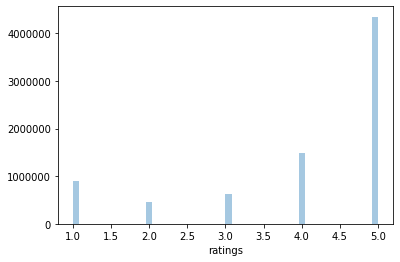

In [53]:
#Checking the fequencies of ratings
sns.distplot(amazon_elect['ratings'], kde = False)

In [54]:
#Count of each rating
np.unique(amazon_elect['ratings'], return_counts=True)

(array([1., 2., 3., 4., 5.]),
 array([ 901765,  456322,  633073, 1485781, 4347541], dtype=int64))

In [55]:
#Unique productIds in the dataset
uniqueProd = np.unique(amazon_elect['productId'], return_counts=True)
print(uniqueProd)
print('Number of unique productIds in the dataset : ',len(uniqueProd[0]))

(array(['0132793040', '0321732944', '0439886341', ..., 'BT008T2BGK',
       'BT008UKTMW', 'BT008V9J9U'], dtype=object), array([ 1,  1,  3, ...,  1, 15,  1], dtype=int64))
Number of unique productIds in the dataset :  476002


In [56]:
#Unique userIds in the dataset
uniqueUser = np.unique(amazon_elect['userId'], return_counts=True)
print(uniqueUser)
print('Number of unique userIds in the dataset : ',len(uniqueUser[0]))

(array(['A00000262KYZUE4J55XGL', 'A000063614T1OE0BUSKUT',
       'A00009182QVLSWIGHLS1B', ..., 'AZZZSIK7NFFVP', 'AZZZWXXUPZ1F3',
       'AZZZY1W55XHZR'], dtype=object), array([1, 2, 1, ..., 1, 1, 1], dtype=int64))
Number of unique userIds in the dataset :  4201696


#### Inference: Dataset consists of 7824482 rating records from 4201696 users and for 476002 products

In [58]:
# Count of ratings and mean ratings received per productId
ratings_mean_count_productId = pd.DataFrame(amazon_elect.groupby('productId')['ratings'].mean())
ratings_mean_count_productId['ratings_count'] = pd.DataFrame(amazon_elect.groupby('productId')['ratings'].count())
print('max count of ratings received by a product =', ratings_mean_count_productId.ratings_count.max())
print('min count of ratings received by a product =',ratings_mean_count_productId.ratings_count.min())
print('Counts of ratings received per productId:')
print(ratings_mean_count_productId.head())

max count of ratings received by a product = 18244
min count of ratings received by a product = 1
Counts of ratings received per productId:
             ratings  ratings_count
productId                          
0132793040  5.000000              1
0321732944  5.000000              1
0439886341  1.666667              3
0511189877  4.500000              6
0528881469  2.851852             27


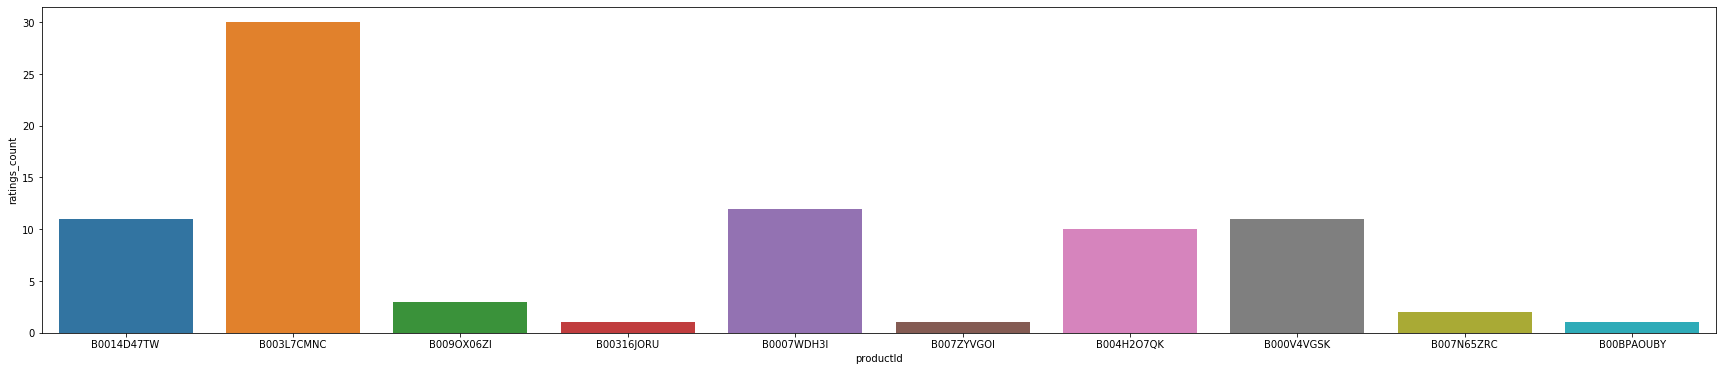

In [60]:
#Plot of ratings_count per productId (plotting only sample of 10 for view as dataset is huge)
df = ratings_mean_count_productId.sample(10)
plt.figure(figsize=(30,6))
sns.barplot(x=df.index, y=df.ratings_count)

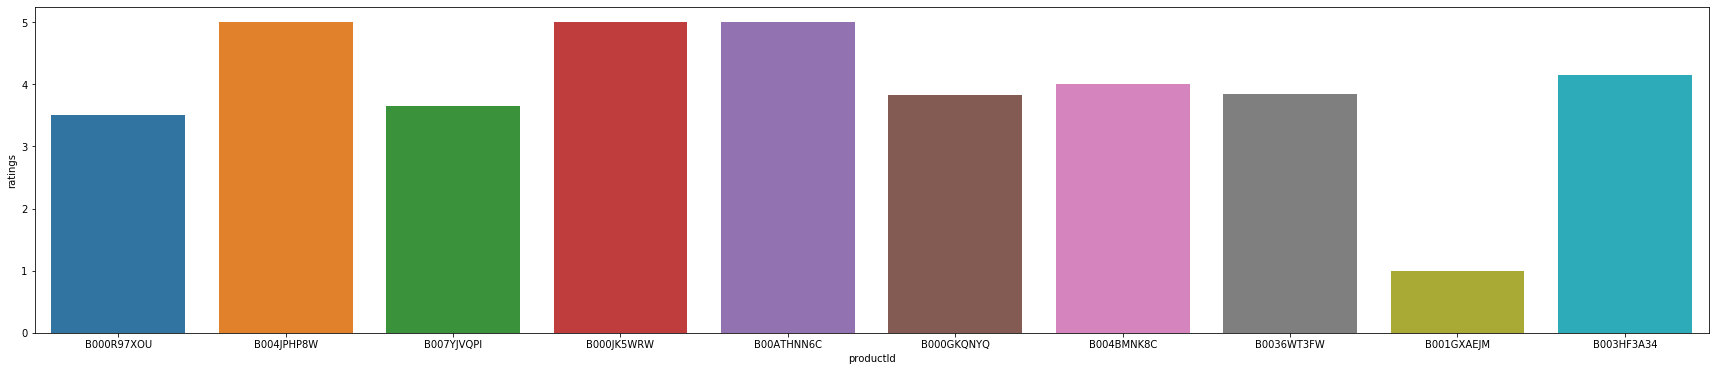

In [61]:
#Plot of mean ratings per productId (plotting only sample of 10 for view as dataset is huge)
df = ratings_mean_count_productId.sample(10)
plt.figure(figsize=(30,6))
sns.barplot(x=df.index, y=df.ratings)

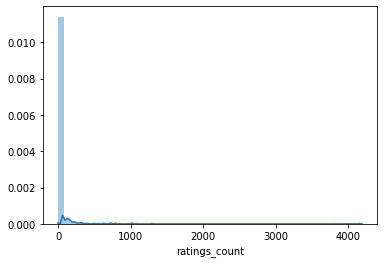

In [62]:
#Distribution plot of ratings_count for sample of dataset (to veiw random sample distribution, for complete distribution whole datafrome input can be given)
df = ratings_mean_count_productId.sample(1000)
sns.distplot(df['ratings_count'], hist = True)

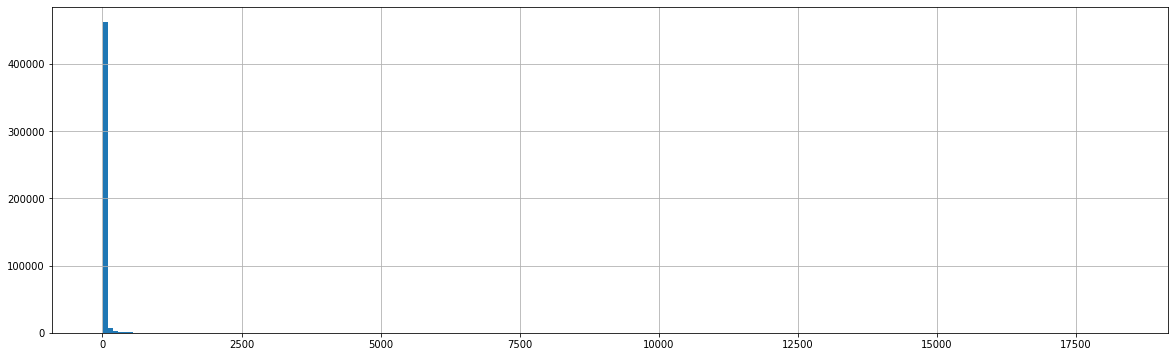

In [63]:
#plot of histogram for the number of ratings represented by the "rating_counts" column.
plt.figure(figsize=(20,6))
ratings_mean_count_productId['ratings_count'].hist(bins= 200)

In [64]:
df = ratings_mean_count_productId[ratings_mean_count_productId.ratings_count <= 50]
print(df.shape)
print(ratings_mean_count_productId.shape)

(450244, 2)
(476002, 2)


From above plots and analysis, it seems that around 95%  of the products have received 50 or less ratings.Only 5% of the products have received more than 50 ratings.

In [65]:
# Count of ratings and mean ratings received per userId
ratings_mean_count_userId = pd.DataFrame(amazon_elect.groupby('userId')['ratings'].mean())
ratings_mean_count_userId['ratings_count'] = pd.DataFrame(amazon_elect.groupby('userId')['ratings'].count())
print('max count of ratings given by a user =', ratings_mean_count_userId.ratings_count.max())
print('min count of ratings given by a user =',ratings_mean_count_userId.ratings_count.min())
print('Counts of ratings received per userId:')
print(ratings_mean_count_userId.sample(10))

max count of ratings given by a user = 520
min count of ratings given by a user = 1
Counts of ratings received per userId:
                 ratings  ratings_count
userId                                 
A196232PKZ5S7O  5.000000              1
A4RAUEQQNB8LS   4.000000              1
A30SSSKZ9MFEC   4.000000              1
ARVKH99HDW8PI   5.000000              1
A2419BZDS4U4D   1.000000              1
A32WXH4TPO64JI  4.666667              3
A33H7L8HCH132P  2.000000              1
A2VDTH4S2DCKD2  4.000000              1
A1VKNPR6AUD7G7  2.000000              2
A2GZKKPE619JE8  5.000000              1


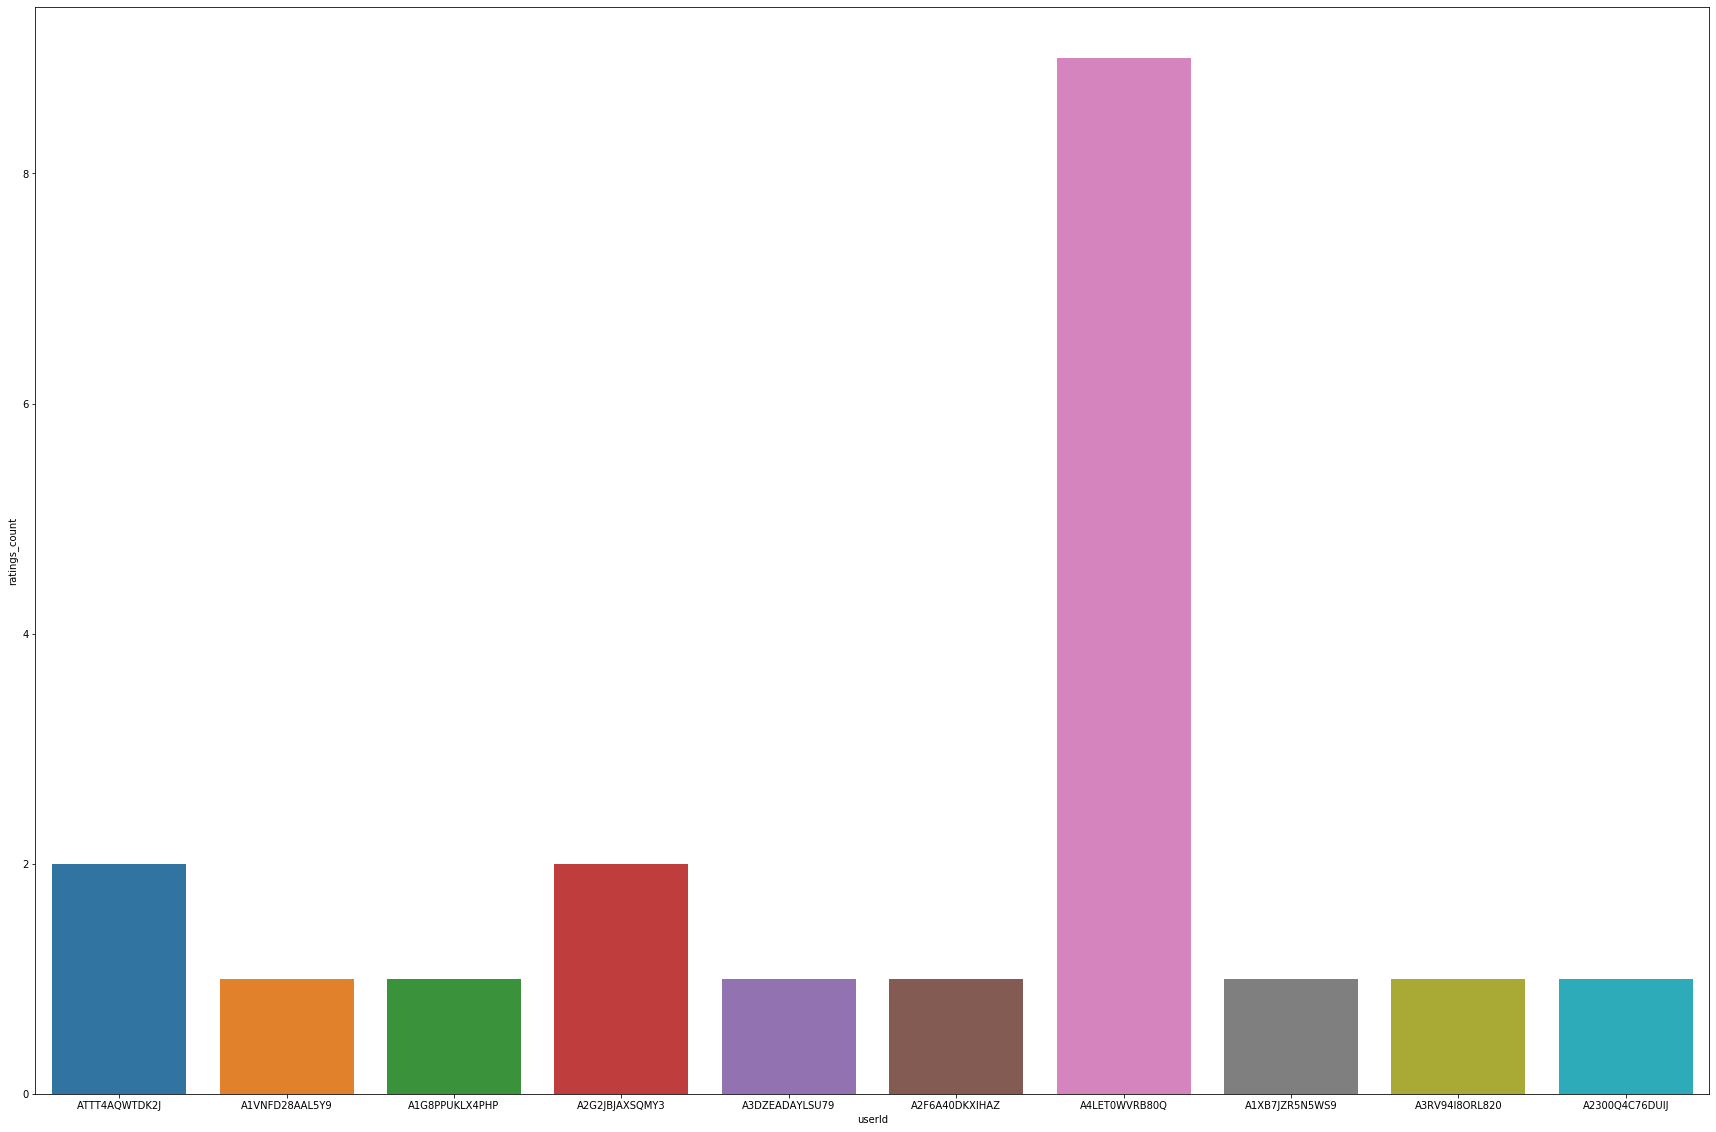

In [66]:
#Plot of ratings_count per userId (sample size can be changed to view wide or small sample)
df = ratings_mean_count_userId.sample(10)
plt.figure(figsize=(30,20))
sns.barplot(x=df.index, y=df.ratings_count)

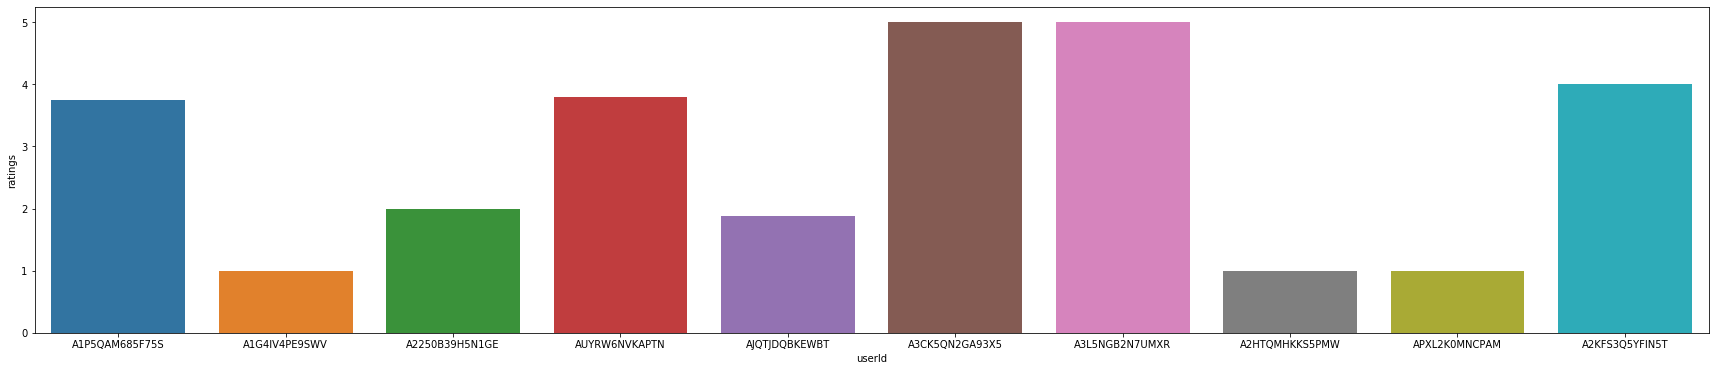

In [67]:
#Plot of mean ratings per userId (sample size can be changed to view wide or small sample)
df = ratings_mean_count_userId.sample(10)
plt.figure(figsize=(30,6))
sns.barplot(x=df.index, y=df.ratings)

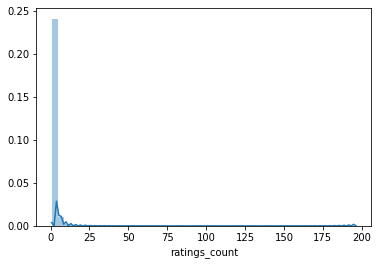

In [68]:
#Distribution plot of ratings_count for sample of dataset (this is to veiw random sample distribution, for complete distribution whole datafrome input can be given)
df = ratings_mean_count_userId.sample(50000)
sns.distplot(df['ratings_count'], hist = True)

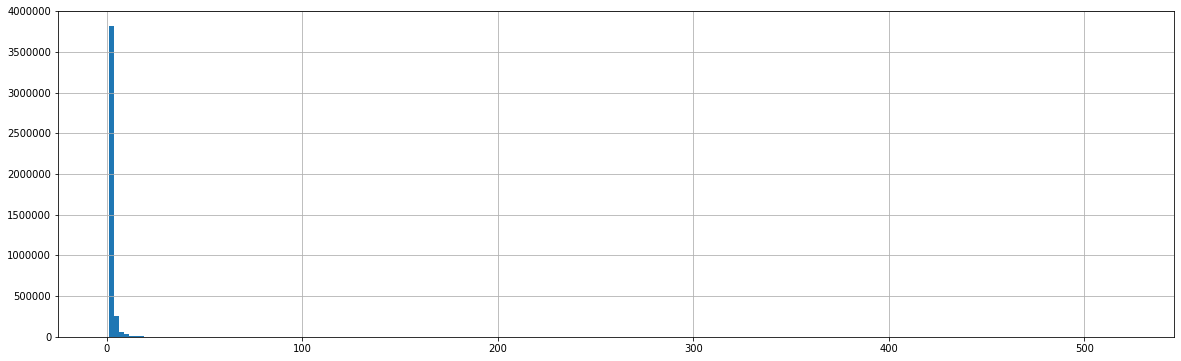

In [69]:
#plot of histogram for the number of ratings represented by the "rating_counts" column.
plt.figure(figsize=(20,6))
ratings_mean_count_userId['ratings_count'].hist(bins= 200)

In [70]:
df = ratings_mean_count_userId[ratings_mean_count_userId.ratings_count <= 5]
print(df.shape)
print(ratings_mean_count_userId.shape)

(4023027, 2)
(4201696, 2)


From above plots and analysis, it seems that around 95% of the users have given 5 or less ratings.Only 5% of the users have given more than 5 ratings.

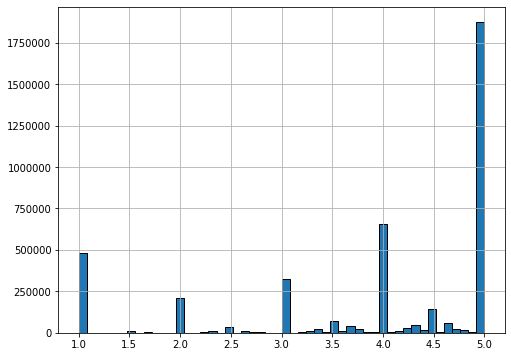

In [71]:
#plot of histogram for average ratings per product
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count_userId['ratings'].hist(bins=50)

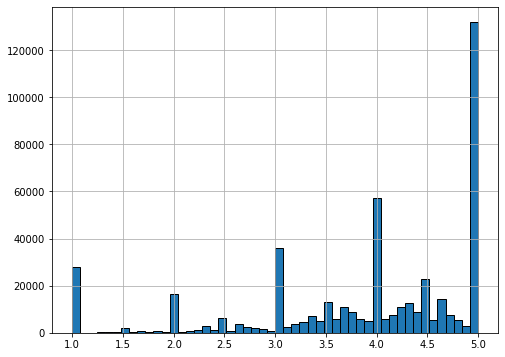

In [72]:
#plot of histogram for average ratings per user
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count_productId['ratings'].hist(bins=50)

Inference: the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5. Furthermore, it is evident that the data has a left skewed distribution

<Figure size 576x432 with 0 Axes>

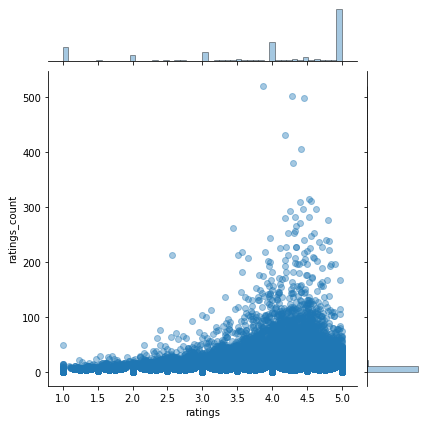

In [74]:
#plot of average ratings against the number of ratings based on userId
plt.figure(figsize=(8,6))
sns.jointplot(x='ratings', y='ratings_count', data=ratings_mean_count_userId, alpha=0.4)

<Figure size 576x432 with 0 Axes>

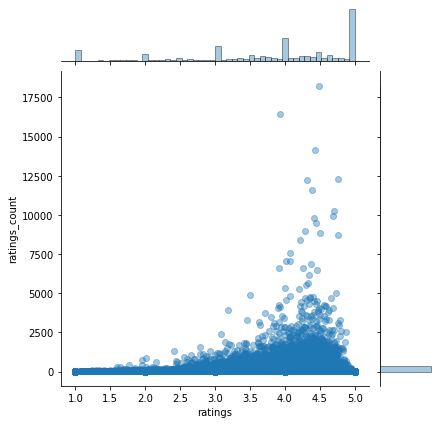

In [75]:
#plot of average ratings against the number of ratings
plt.figure(figsize=(8,6))
sns.jointplot(x='ratings', y='ratings_count', data=ratings_mean_count_productId, alpha=0.4)

Inference: The graph shows that, in general, products with higher average ratings actually have more number of ratings, compared with products that have lower average ratings.

### 2.Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [76]:
#Considering the subset of dataset with users who rated 50 or more products
counts = amazon_elect['userId'].value_counts()
amazon_elect_50 = amazon_elect[amazon_elect['userId'].isin(counts[counts >= 50].index)]

In [77]:
amazon_elect_50.shape

(125871, 3)

In [78]:
amazon_elect_50.ratings.unique()

array([5., 3., 1., 4., 2.])

### 3.Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [79]:
reader = Reader(rating_scale=(1, 5))
amazon_elect_surprise = Dataset.load_from_df(amazon_elect_50[['userId', 'productId', 'ratings']], reader)
trainset, testset = train_test_split(amazon_elect_surprise, test_size=.30, random_state=7)

### 4.Build Popularity Recommender model.

In [80]:
amazon_elect_50.groupby('productId')['ratings'].mean().head()

productId
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: ratings, dtype: float64

In [81]:
amazon_elect_50.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: ratings, dtype: float64

In [82]:
amazon_elect_50.groupby('productId')['ratings'].count().sort_values(ascending=False).head()

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

In [83]:
ratings_mean_count = pd.DataFrame(amazon_elect_50.groupby('productId')['ratings'].mean())

In [84]:
ratings_mean_count['rating_counts'] = pd.DataFrame(amazon_elect_50.groupby('productId')['ratings'].count())

In [85]:
ratings_mean_count.head()

,ratings,rating_counts
productId,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [86]:
ratings_mean_count.sort_values(by='rating_counts', ascending=False).head(10)

,ratings,rating_counts
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149
B008DWCRQW,4.094891,137
B00829THK0,4.416058,137
B002R5AM7C,4.125000,128
B004CLYEDC,4.669492,118


### 5.Build Collaborative Filtering model.

In [87]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 6.Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

In [88]:
predictions = algo.test(testset)

In [89]:
# get RMSE,MSE,MAE
print("User-based Model : Test Set")
print(accuracy.rmse(predictions, verbose=True))
print(accuracy.mse(predictions, verbose=True))
print(accuracy.mae(predictions, verbose=True))

User-based Model : Test Set
RMSE: 1.0583
1.0582602986711025
MSE: 1.1199
1.119914859743451
MAE:  0.7801
0.7800712308985314


In [90]:
predictions[:5]

[Prediction(uid='AQR4HPVSOPS08', iid='B001Q3MA80', r_ui=5.0, est=4.592592592592593, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1NJHKPHD4YWZV', iid='B000HGHMF8', r_ui=5.0, est=3.96, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2UOHALGF2X77Q', iid='B000V0BXLE', r_ui=5.0, est=4.333333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3E049PVKG7NDK', iid='B003OYCBM4', r_ui=4.0, est=4.261244594763305, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1VVRA3P6G1TWH', iid='B00004ZCJE', r_ui=4.0, est=4.467803030303029, details={'actual_k': 1, 'was_impossible': False})]

### 7.Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [91]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [92]:
top_n = get_top_n(predictions, n=5)

In [93]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

AQR4HPVSOPS08 ['B001TOD7ME', 'B003ES5ZUU', 'B001Q3MA80', 'B003FVVMS0', 'B004B8GF7Y']
A1NJHKPHD4YWZV ['B0017PPQSI', 'B001L7XAJ4', 'B0056XGGDQ', 'B000UDBMZE', 'B00CUA97J8']
A2UOHALGF2X77Q ['B00FE8MKTM', 'B0067WUSGQ', 'B000OGX5AM', 'B00ATM1MGA', 'B000LRMS66']
A3E049PVKG7NDK ['B00024ENES', 'B00B9BUZW2', 'B004DI7DFU', 'B002N38S6U', 'B00EUZV546']
A1VVRA3P6G1TWH ['B000053HH5', 'B00006I53X', 'B00004ZCJE', 'B0000DCE6I', 'B0000AE66D']
A2X695AM08AIN1 ['B007WTAJTO', 'B00511PS3C', 'B002WE6D44', 'B005J064XS', 'B006YW3DI4']
A2X61KKXXR6WNP ['B0081FLFQE', 'B001DJ64C0', 'B000IZDN60', 'B000FITKK8', 'B000GUSQJG']
AEWYUPCNDV7HY ['B0035FZ12O', 'B0001DBEM4', 'B00006B7DA', 'B003LSTD3I', 'B004CLYEDC']
A1L5TA5UQF7EWE ['B006GWDJXQ', 'B008X0YZM8', 'B00DR0PDNE', 'B004I4YPB4', 'B008RGD114']
A3KZEGBTPH6MMF ['B00HSUMSIM', 'B0047H2KZK', 'B005A2RLXC', 'B003ES5ZUU', 'B004N627KS']
AGATRDOFW48DK ['B000IMYAVU', 'B006G77LAI', 'B006G78HMO', 'B005MLAHYG', 'B000GQU5ZS']
AGFSSC5DBY2HU ['B00IVFDZBC', 'B002DW99H8', 'B0092MD8OW', 